# The purpose of this notebook is to get data from multiple data sources and transform them to common structure.

In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# VARIABLES
pd.options.mode.chained_assignment = None
DF_MERGED_DELETE_OUTLIERS = True

In [5]:
def text_analysis(df):
    """
    counts: capital letters, small letters, special characters, blank signs, numbers, letters (small + capital)
    """
    nan_titles = df.isnull().values.any() 
    print(f"\nNaN titles dropped: { nan_titles }")
    df = df.dropna(subset=['title'])
    
    df["char_capital"] = df["title"].apply(lambda title: sum(1 for char in title if char.isupper()))
    df["char_small"] = df["title"].apply(lambda title: sum(1 for char in title if char.islower()))
    df["char_special"] = df["title"].apply(lambda title: sum(1 for char in title if not char.isalnum() and not char.isspace()))
    df["blank"] = df["title"].apply(lambda title: sum(1 for char in title if char.isspace()))
    df["numerical"] = df["title"].apply(lambda title: sum(1 for char in title if char.isdigit())) 
    df["letters"] = df["title"].apply(lambda title: sum(1 for char in title if char.isalpha()))
    
    # print(f"\nEmpty titles dropped: {sum(df["letters"] == 0)}")
    
    df = df.loc[df["letters"]!=0]
    return df

In [6]:
def plot_letters(df):
    """
    plots boxplot and histogram with number of letters
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    df.boxplot(column=["letters"], ax=axs[0])
    axs[0].set_title('Boxplot of alphabetical characters in titles')

    sns.histplot(df["letters"], bins=10, kde=True, ax=axs[1], edgecolor="black")
    axs[1].set_xlabel('Counts')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of alphabetical characters in titles')

    plt.tight_layout()
    plt.show()

In [7]:
def outliers_iqr(df):
    """
    detect outliers by IQR criteria
    returns outliers Pandas.df and updated original df
    """
    Q1 = df["letters"].quantile(0.25)
    Q3 = df["letters"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df["outlier"] = np.where((df["letters"] < lower_bound) | (df["letters"] > upper_bound), 1, 0)
    outliers = df[df["outlier"]==1].copy()
    outliers["tail"] = outliers["letters"].apply(lambda count: "L" if count < lower_bound else "U")
    outliers = outliers.groupby(["tail", "clickbait"])["clickbait"].count().reset_index(name='count')
    return outliers, df

In [8]:
def plot_outliers(outliers):
    """
    plots 2 barplots with outliers above and beneath bounds
    """
    lower_outliers = outliers[outliers['tail'] == 'L']
    upper_outliers = outliers[outliers['tail'] == 'U']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(x='clickbait', y='count', data=lower_outliers, ax=axs[0], hue="clickbait", palette={0: 'green', 1: 'red'})
    axs[0].set_title('Less alphabetical than lower bound IQR')
    axs[0].set_xlabel('Clickbait')
    axs[0].set_ylabel('Count')
    axs[0].set_xticks(ticks=[0, 1], labels=['Non-Clickbait (0)', 'Clickbait (1)'])

    sns.barplot(x='clickbait', y='count', data=upper_outliers, ax=axs[1], hue="clickbait", palette={0: 'green', 1: 'red'})
    axs[1].set_title('More alphabetical than upper bound IQR')
    axs[1].set_xlabel('Clickbait')
    axs[1].set_ylabel('Count')
    axs[1].set_xticks(ticks=[0, 1], labels=['Non-Clickbait (0)', 'Clickbait (1)'])

    plt.tight_layout()
    plt.show()

In [9]:
def clickbait_dist_plot(df):
        """
        piechart with clickbait distribution
        """
        print(f"\nShape: {df.shape}")
        num_clickbaits = df[df["clickbait"] == 1].shape[0]
        num_no_clickbaits = df[df["clickbait"] == 0].shape[0]

        print(f"Number of clickbaits: {num_clickbaits}")
        print(f"Number of no-clickbaits: {num_no_clickbaits}")

        labels = ['Clickbait', 'No-clickbait']
        sizes = [num_clickbaits, num_no_clickbaits]
        colors = ['red', 'green']
        explode = (0, 0)

        plt.figure(figsize=(8, 6))
        plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=False, startangle=90)
        plt.axis('equal')
        plt.title('Distribution of Clickbaits and No Clickbaits')
        plt.show()

In [10]:
def plot_clickbait_vs_noclickbait(df):
    """
    plots boxplots with comparison in features between clickbait and no-clickbait articles
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    data_1 = df[df["char_capital"] >= df["char_small"]]
    data_2 = df[df["numerical"] != 0]
    data_3 = df[df["char_special"] != 0]
    titles = [
        'Titles with more capital than small letters',
        'Titles with numerical data',
        'Titles with special characters'
    ]
    datasets = [data_1, data_2, data_3]

    for i in range(len(datasets)):
        dataset = datasets[i].groupby(["clickbait"])["clickbait"].count().reset_index(name='count')
        axs[i].bar(dataset['clickbait'], dataset['count'], color=['green', 'red'])

        axs[i].set_xlabel('Clickbait (0 = No, 1 = Yes)')
        axs[i].set_ylabel('Count')
        axs[i].set_title(titles[i])
        axs[i].set_xticks(dataset['clickbait'])

        axs[i].grid(axis='y')

    plt.tight_layout()
    plt.show()

In [11]:
def remove_outliers(df):
    return df.loc[df["outlier"]==0]

In [12]:
def print_stats(df):
    stats = df.drop(columns=["title"]).groupby('clickbait').agg(['mean', 'std'])
    print("\nStats:\n", stats)

In [13]:
def analyze_df(df, delete_outliers=False):
    """
    pipeline with above methods
    """
    columns = df.columns.tolist()
    print(f"Columns: {columns}")
    clickbait_dist_plot(df)
    df = text_analysis(df)
    print_stats(df)
    print("With outliers:")
    plot_letters(df)
    outliers, df = outliers_iqr(df)
    plot_outliers(outliers)
    if delete_outliers:    
        df = remove_outliers(df)
        print("Without outliers:")
        plot_letters(df)
    plot_clickbait_vs_noclickbait(df)
    return df[columns]

 ## #1 Data source: kaggle
 https://www.kaggle.com/datasets/amananandrai/clickbait-dataset

In [14]:
df_1 = pd.read_csv("../data/clickbait_data.csv")
df_1.rename(columns={'headline': 'title'}, inplace=True)

Columns: ['title', 'clickbait']

Shape: (32000, 2)
Number of clickbaits: 15999
Number of no-clickbaits: 16001


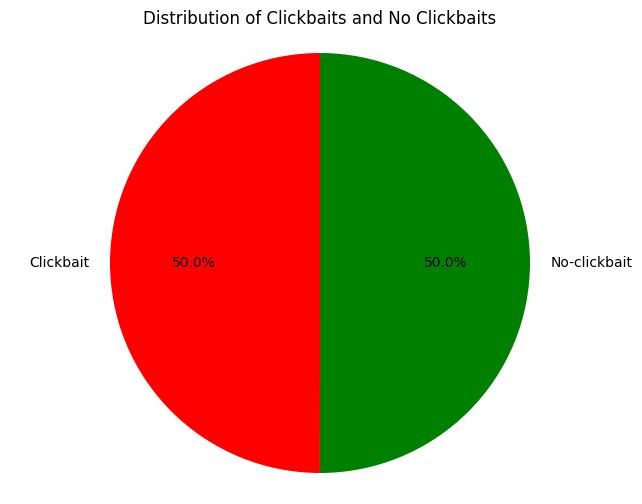


NaN titles dropped: False

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             4.631273  2.469242  38.795013  12.265831     0.721455  1.015306   
1             9.688356  2.866690  35.308957  10.295818     0.754047  1.074927   

              blank           numerical              letters             
               mean       std      mean       std       mean        std  
clickbait                                                                
0          7.194988  2.227746  0.510593  1.248460  43.426286  12.262935  
1          8.942684  2.660435  1.047003  1.427426  44.997312  12.532420  
With outliers:


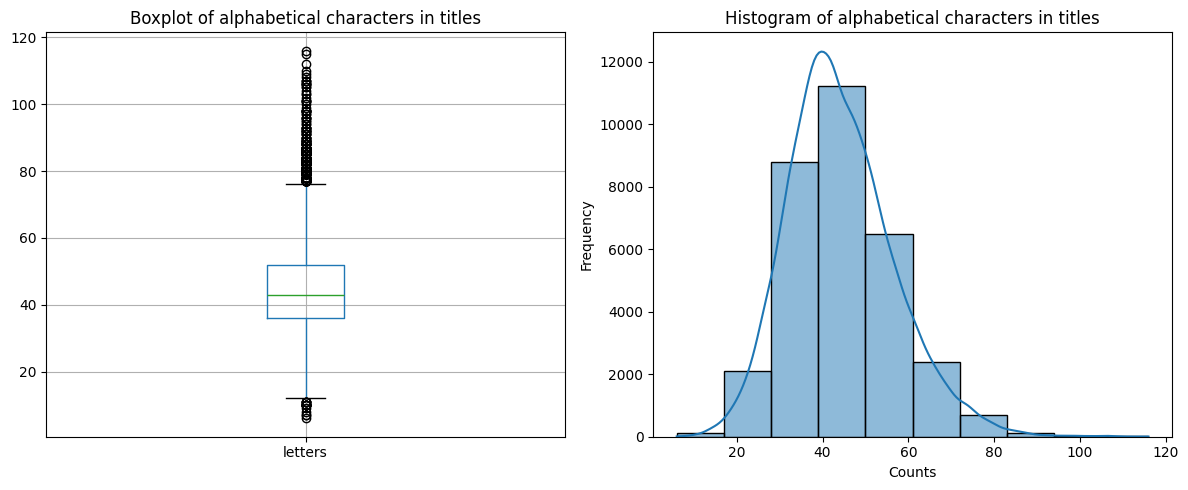

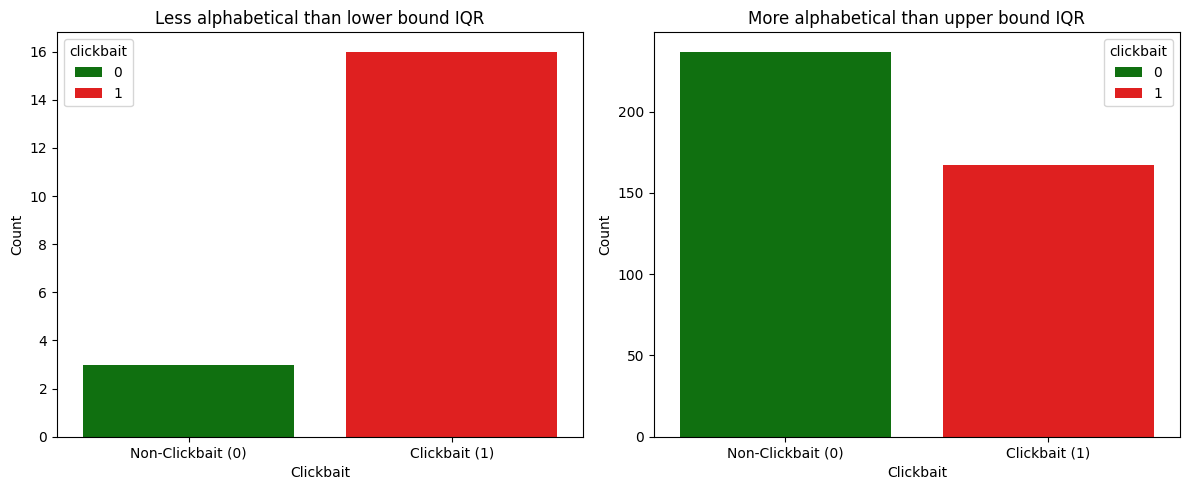

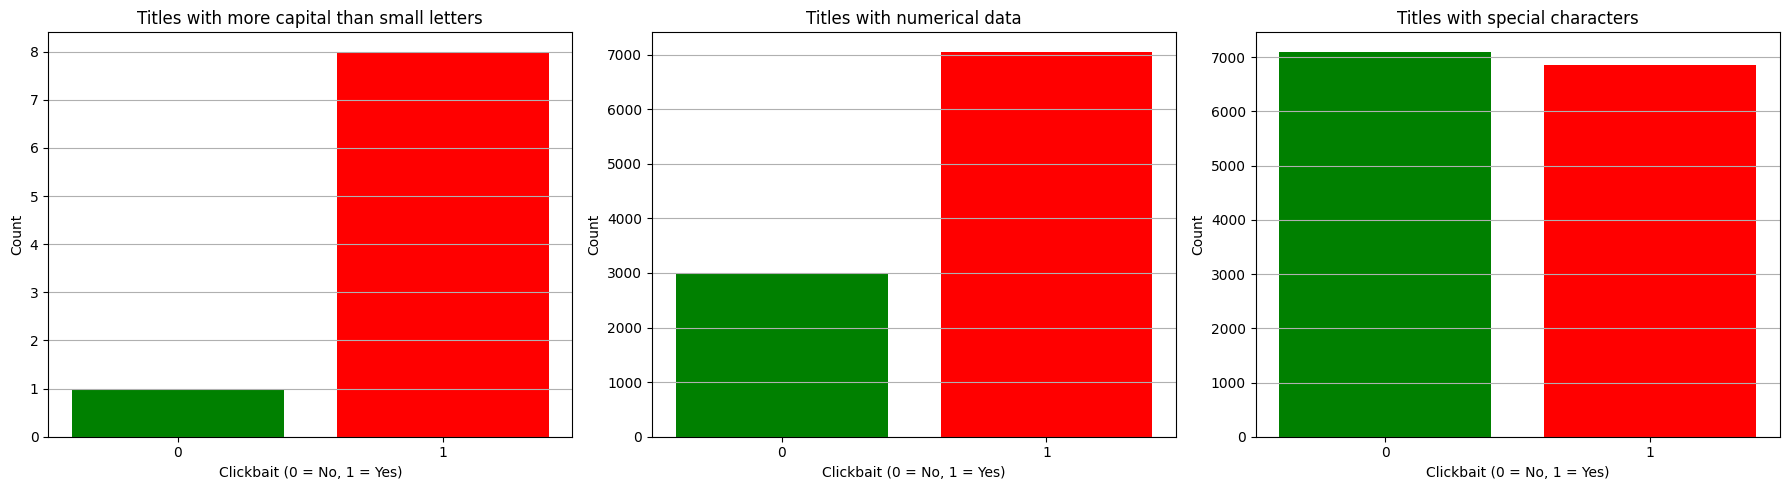

,title,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [15]:
df_1.head()
analyze_df(df_1)

 ## #2 Data source: kaggle 
https://www.kaggle.com/datasets/vikassingh1996/news-clickbait-dataset?select=train2.csv

In [16]:
df_news_2 = pd.read_csv("../data/train2.csv")
df_news_2['label'] = df_news_2['label'].apply(lambda x: 1 if x == 'clickbait' else 0)

df_news_2.rename(columns={'label': 'clickbait'}, inplace=True)
df_2 = df_news_2[['title', 'clickbait']]

Columns: ['title', 'clickbait']

Shape: (21029, 2)
Number of clickbaits: 4291
Number of no-clickbaits: 16738


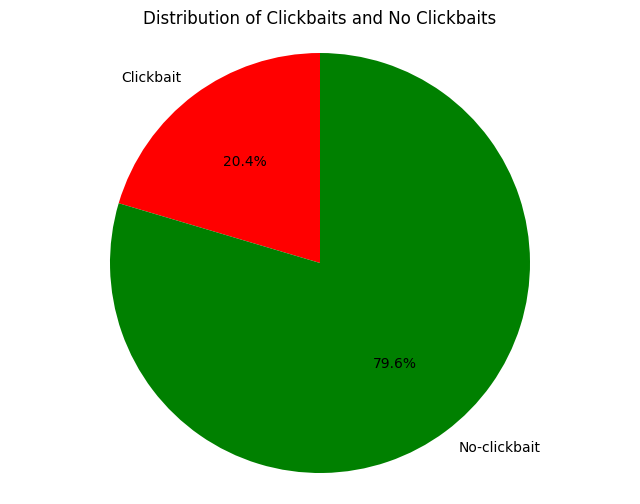


NaN titles dropped: False

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             7.007827  7.600632   54.32005  77.619362     1.817242  2.488330   
1             7.541133  8.086558   52.29457  88.087041     1.744349  2.739785   

               blank            numerical              letters             
                mean        std      mean       std       mean        std  
clickbait                                                                  
0          11.277453  15.941286  0.562254  1.518829  61.327877  83.707279  
1          11.496854  18.443404  0.805407  1.672381  59.835703  94.374176  
With outliers:


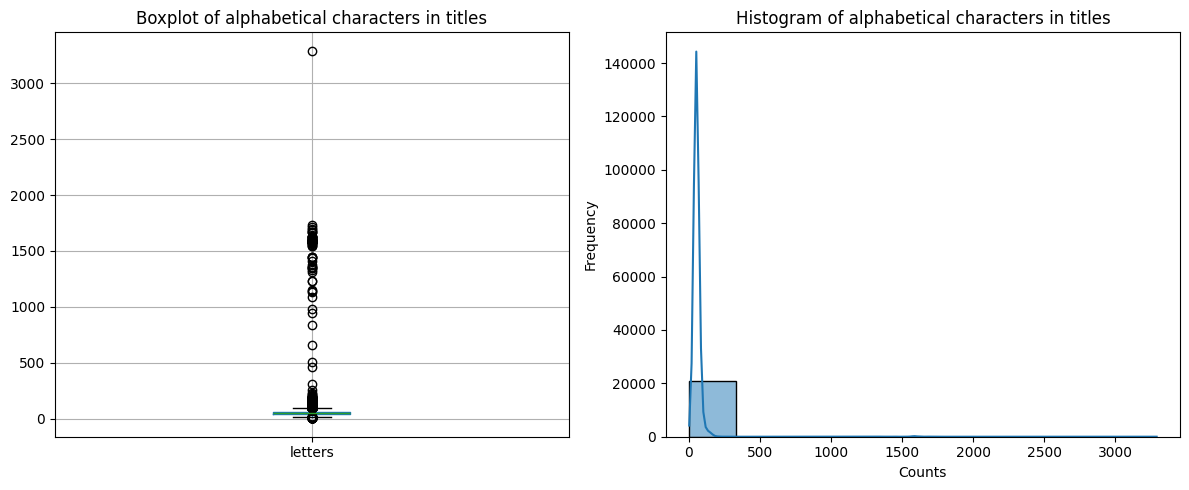

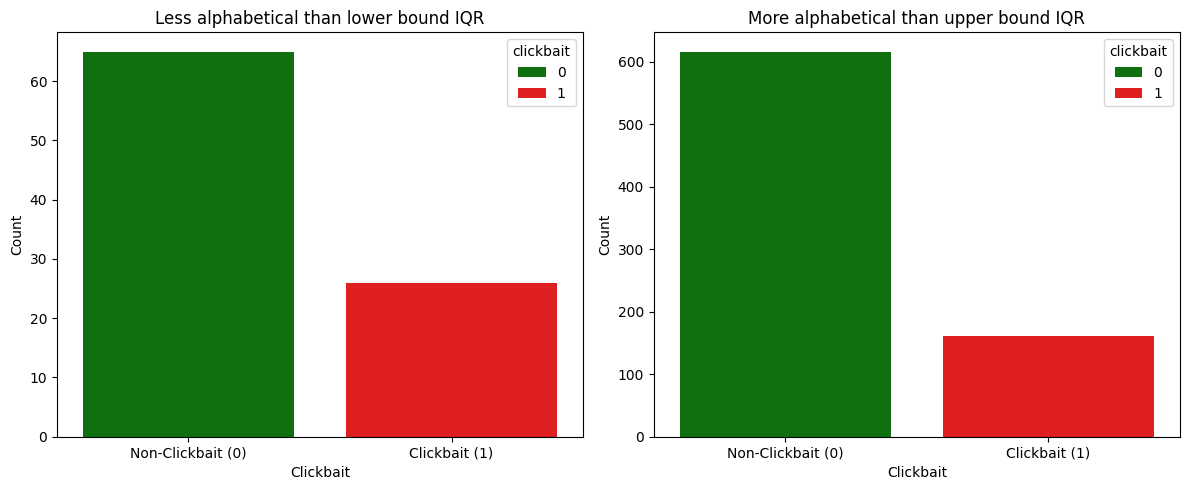

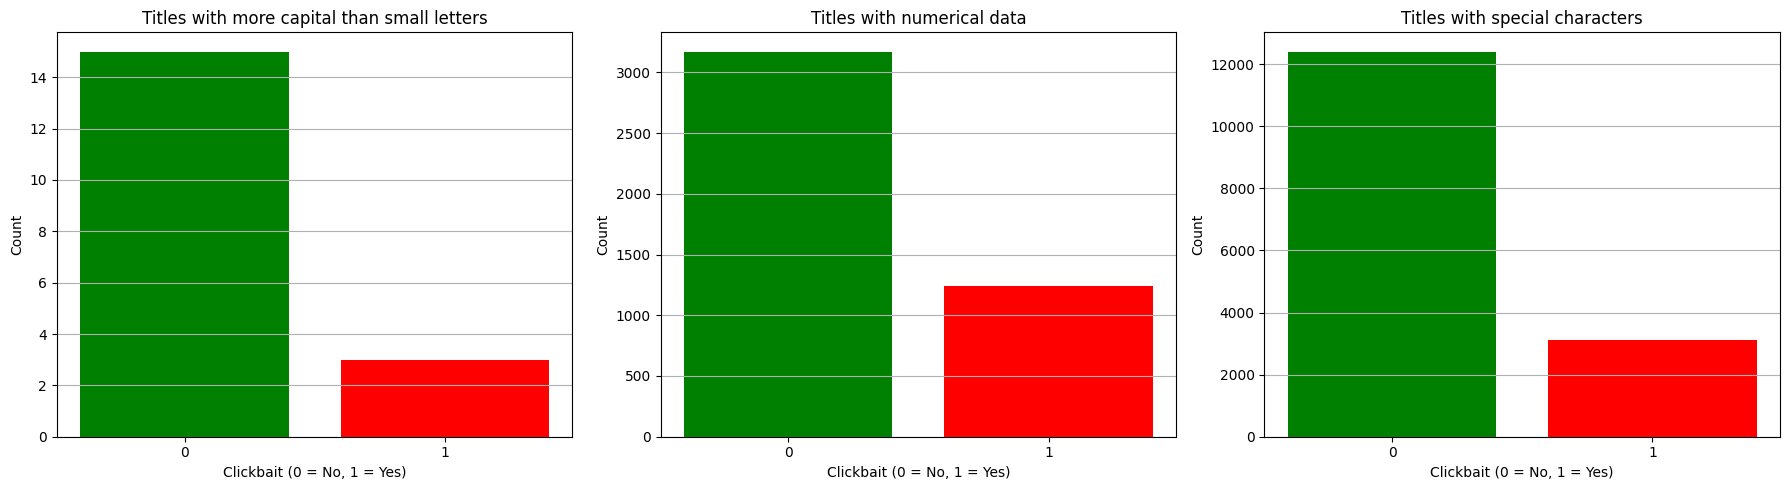

In [17]:
df_2.head()
df_2 = analyze_df(df_2)

 ## #3 Data source: clickbait challenge 
https://webis.de/events/clickbait-challenge/shared-task.html

In [18]:
def load_data_cc(name, columns=[]):
    """
    loads data from clickbait challenge webis corpus
    
    name (str): name of the folder
    columns (list): list of columns names to extract apart from 'id' and 'targetTitle'
    """
    data_file_path = f'../data/{name}/instances.jsonl'
    with open(data_file_path, 'rb') as file:
        data_df = pd.read_json(file,lines=True)

    target_file_path = f'../data/{name}/truth.jsonl'
    with open(target_file_path, 'rb') as file:
        labels = pd.read_json(file,lines=True)
    
    data_df = data_df[["id", "targetTitle"] + columns]
    labels = labels[["id", "truthClass"]]

    df = pd.merge(data_df, labels, on='id', how='left')
    df.drop(['id'], axis=1, inplace=True)
    df['truthClass'] = df['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)
    df.rename(columns={'targetTitle': 'title', 'truthClass': 'clickbait'}, inplace=True)
    return df

In [51]:
files = [
    "clickbait17-train-170331", 
    "clickbait17-test-170720", 
    "clickbait17-validation-170630"
]
body_dfs = []
for filename in files:
    part_df = load_data_cc(filename)
    part_df = part_df[['title', 'clickbait']]
    body_dfs.append(part_df)
df_3 = pd.concat(body_dfs).reset_index(drop=True)
df_3 = df_3.drop_duplicates()

print(df_3.shape)

(38830, 2)


In [52]:
df_3

,title,clickbait
0,Apple gives back gigabytes: iOS 9 'app thinnin...,0
1,Emerging Markets Suffer Largest Outflow in Sev...,0
2,U.S. Soccer should start answering tough quest...,1
3,How theme parks like Disney World left the mid...,0
4,Warning labels on your light bulbs,1
...,...,...
40971,"NBC News Video See Brazil Soccer Team, Pilot’s...",0
40972,Politico Scoop: Eric Trump Killed Two Deer,1
40973,Frenchs Forest high school may relocate to mak...,0
40974,Los Angeles Rams Jeff Fisher May Think Danny W...,0


Columns: ['title', 'clickbait']

Shape: (38830, 2)
Number of clickbaits: 9530
Number of no-clickbaits: 29300


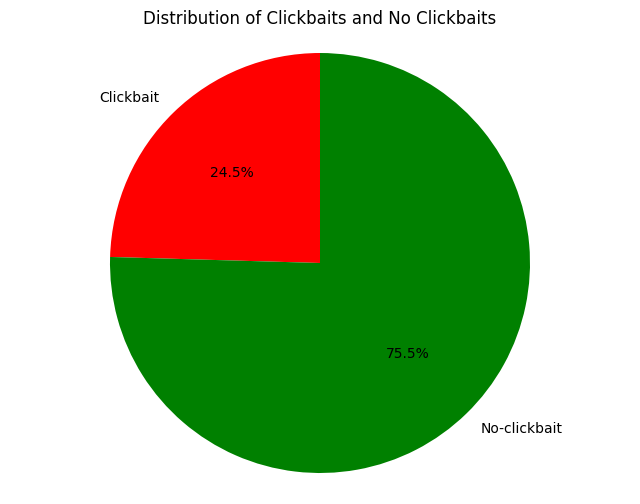


NaN titles dropped: False

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             7.042082  7.195388  54.745427  69.125018     1.758020  2.729074   
1             7.500105  8.239454  50.947429  73.271862     1.765582  2.750367   

               blank            numerical              letters             
                mean        std      mean       std       mean        std  
clickbait                                                                  
0          11.378498  14.259585  0.590410  1.492527  61.787509  74.467116  
1          11.241658  15.637764  0.804512  1.803112  58.449213  79.268846  
With outliers:


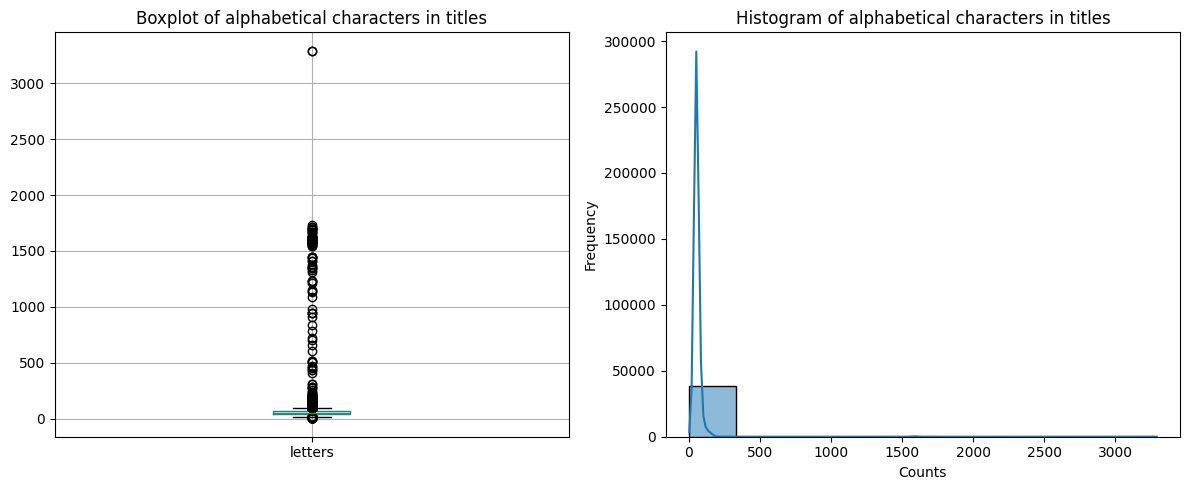

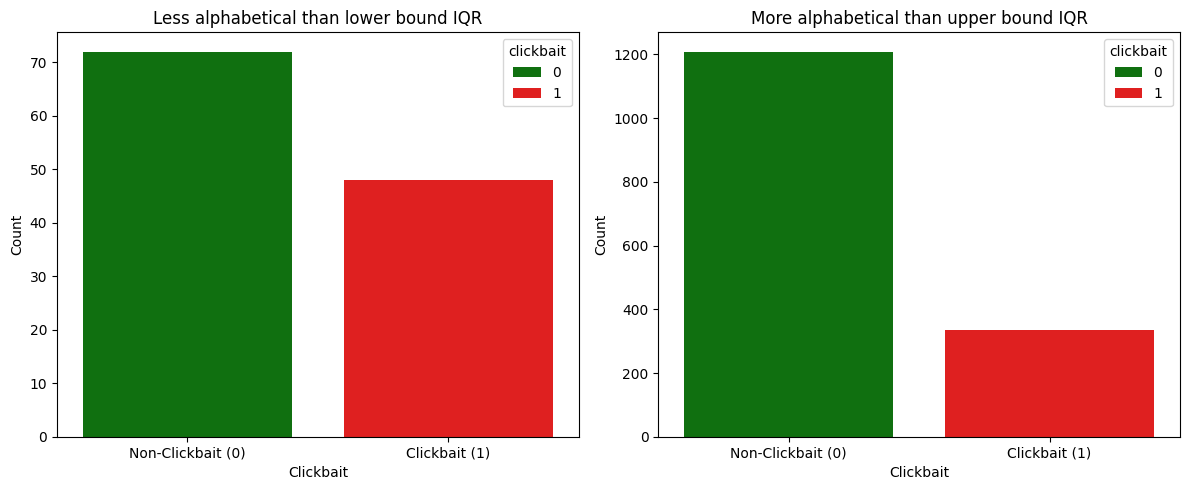

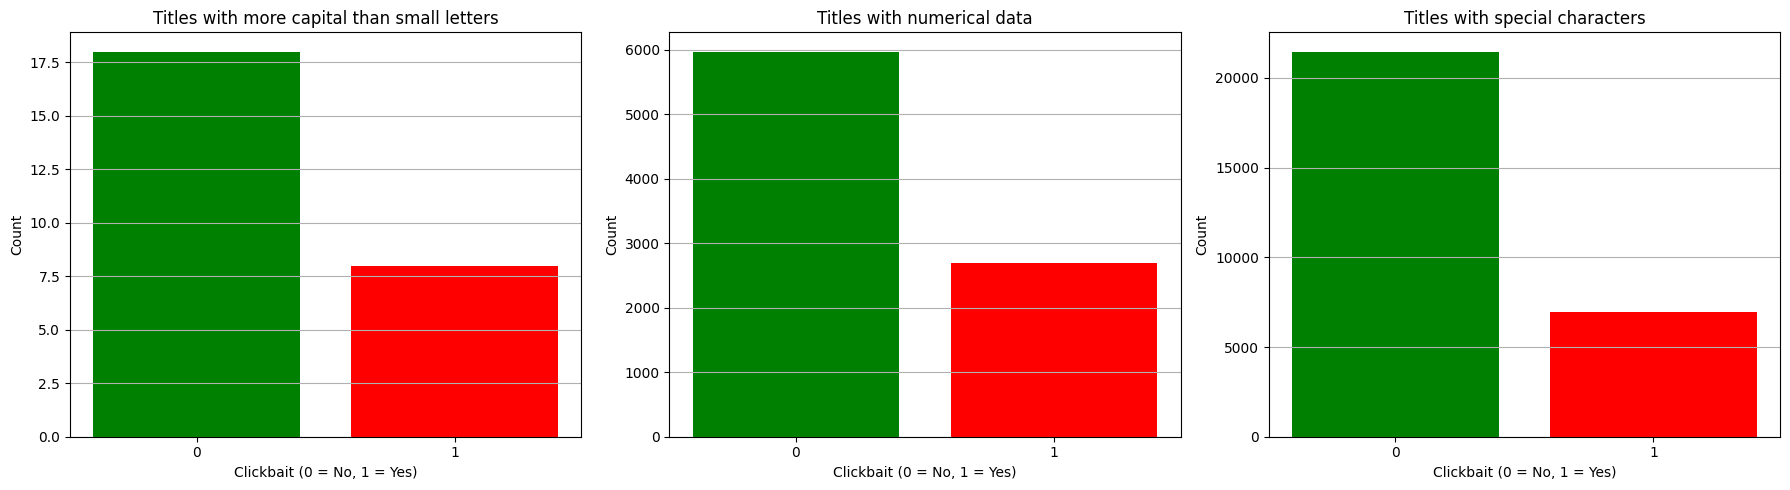

,title,clickbait
0,Apple gives back gigabytes: iOS 9 'app thinnin...,0
1,Emerging Markets Suffer Largest Outflow in Sev...,0
2,U.S. Soccer should start answering tough quest...,1
3,How theme parks like Disney World left the mid...,0
4,Warning labels on your light bulbs,1
...,...,...
40971,"NBC News Video See Brazil Soccer Team, Pilot’s...",0
40972,Politico Scoop: Eric Trump Killed Two Deer,1
40973,Frenchs Forest high school may relocate to mak...,0
40974,Los Angeles Rams Jeff Fisher May Think Danny W...,0


In [54]:
df_3.head()
analyze_df(df_3)

## Concatenate datasets

In [55]:
dfs = [
    df_1,
    df_2,
    df_3,
]

In [56]:
for df_ in dfs:
    print(df_.shape)

(10000, 2)
(21029, 2)
(38830, 2)


In [57]:
for i,df_ in enumerate(dfs):
    print("=========  " + str(i+1) +"- dataset =============")
    print(df_["clickbait"].value_counts())

=========  1- dataset =============
clickbait
1    10000
Name: count, dtype: int64
=========  2- dataset =============
clickbait
0    16738
1     4291
Name: count, dtype: int64
=========  3- dataset =============
clickbait
0    29300
1     9530
Name: count, dtype: int64


In [58]:
df_merged = pd.concat([df_1,df_2,df_3])

Columns: ['title', 'clickbait']

Shape: (69859, 2)
Number of clickbaits: 23821
Number of no-clickbaits: 46038


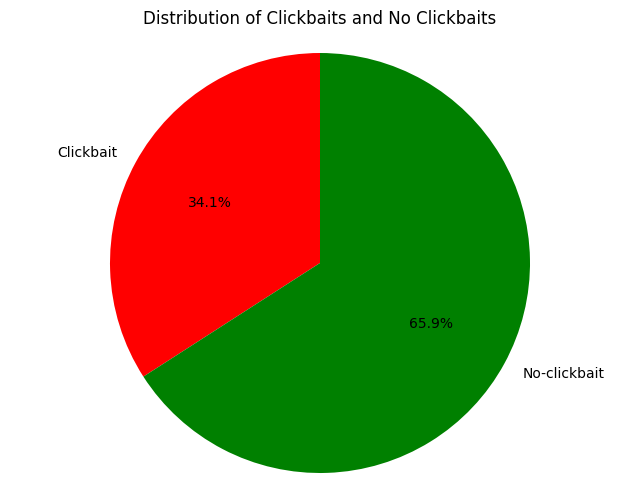


NaN titles dropped: False

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             7.029628  7.345246  54.590773  72.328258     1.779552  2.644210   
1             7.934470  6.783941  46.471013  60.413982     1.494060  2.291557   

               blank            numerical              letters             
                mean        std      mean       std       mean        std  
clickbait                                                                  
0          11.341761  14.892893  0.580173  1.502187  61.620401  77.952786  
1          10.523740  12.794405  0.855716  1.651159  54.406154  65.040328  
With outliers:


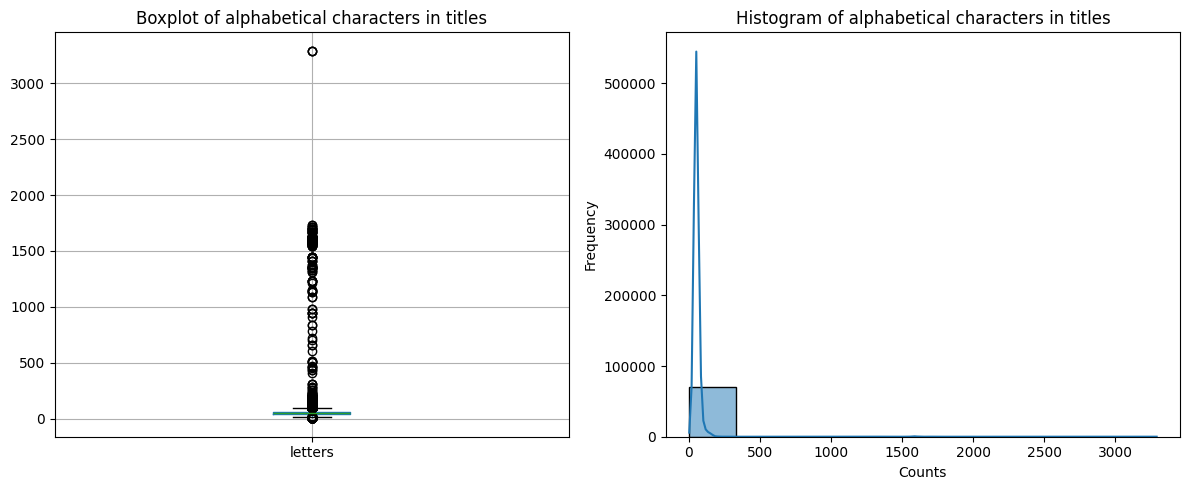

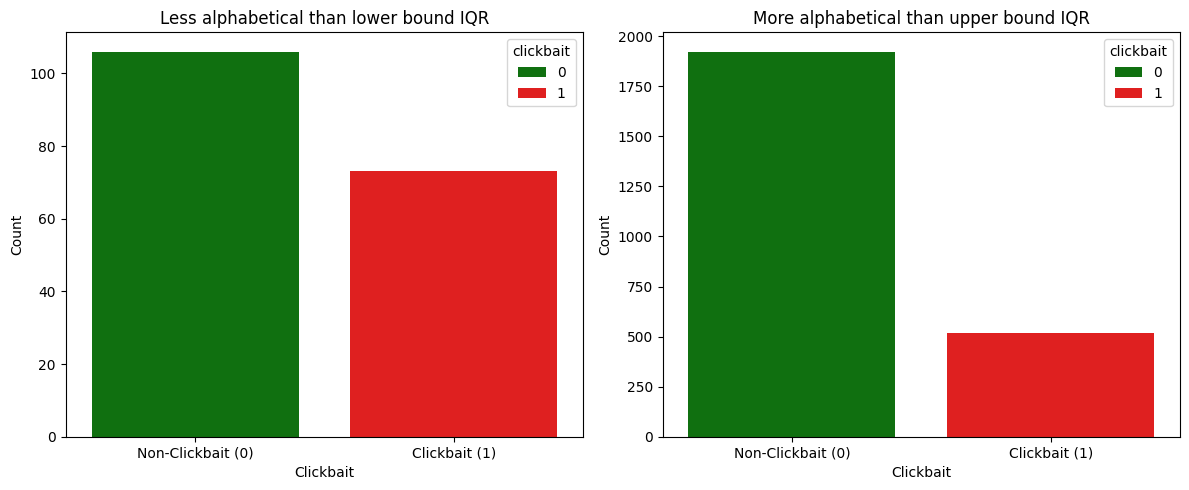

Without outliers:


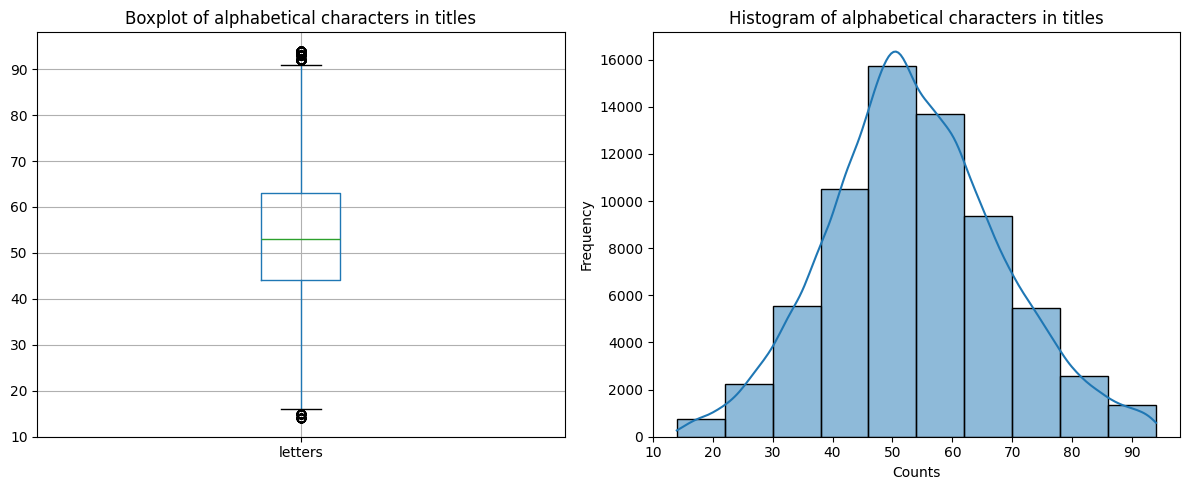

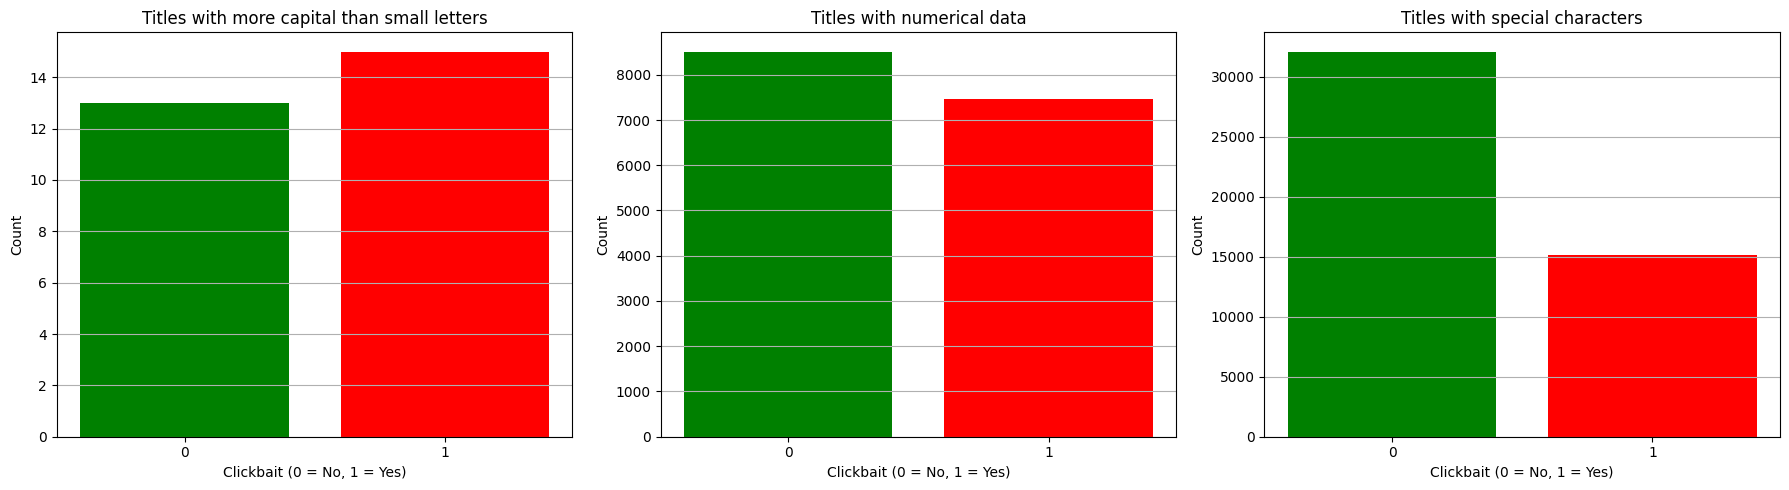

In [59]:
df_merged = analyze_df(df_merged, delete_outliers=DF_MERGED_DELETE_OUTLIERS)

In [60]:
df_merged.to_csv("../data/merged_all_datasets.csv", index=False)

Columns: ['title', 'clickbait']

Shape: (67237, 2)
Number of clickbaits: 23228
Number of no-clickbaits: 44009


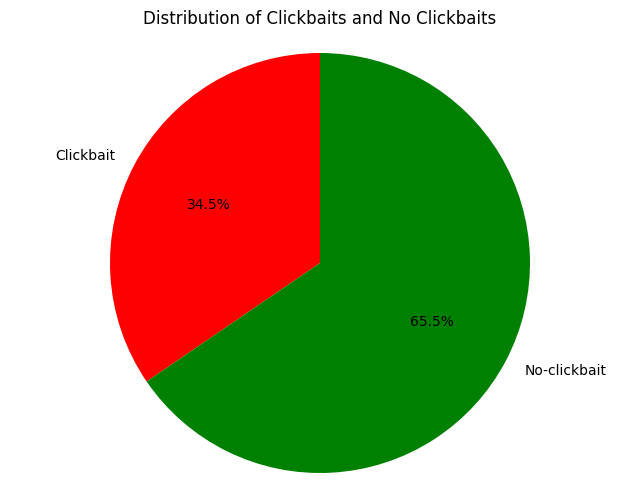


NaN titles dropped: False

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             6.733418  4.300953  48.507487  13.439830     1.634802  1.540436   
1             7.740744  4.487267  42.897279  13.943914     1.396849  1.491842   

               blank           numerical              letters             
                mean       std      mean       std       mean        std  
clickbait                                                                 
0          10.085551  3.003183  0.528278  1.268985  55.240905  13.909335  
1           9.772215  3.145828  0.830937  1.484860  50.638712  14.937692  
With outliers:


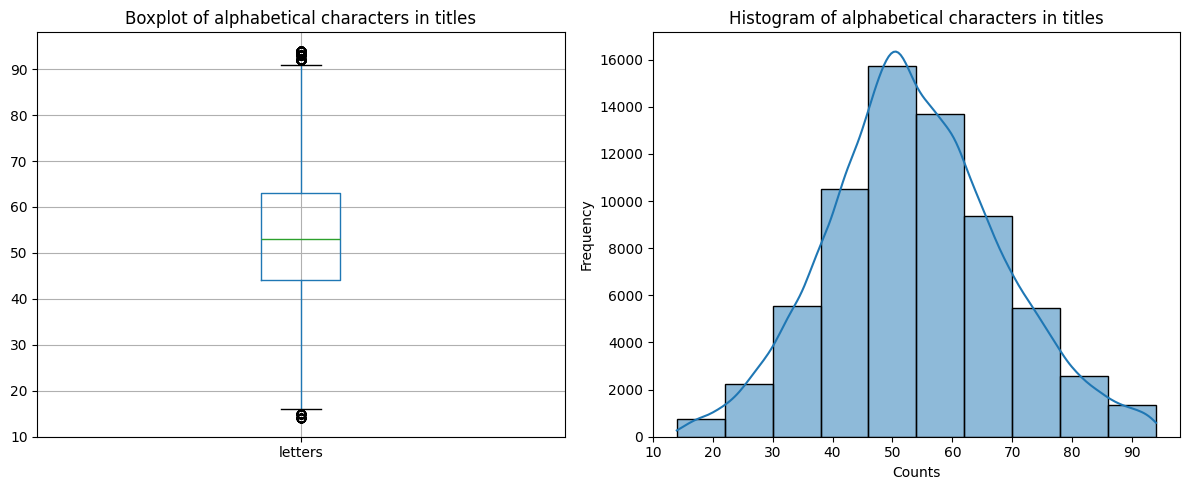

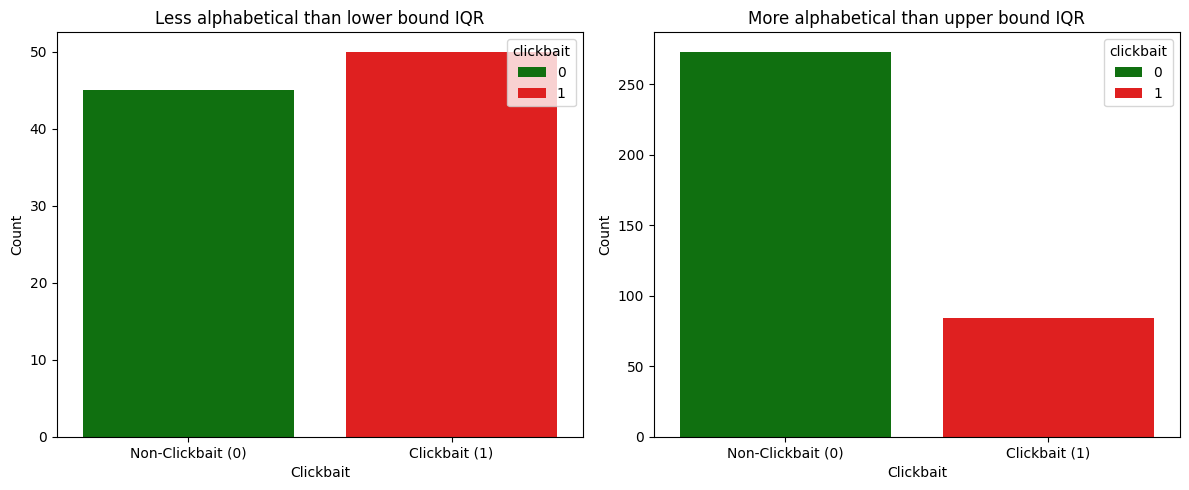

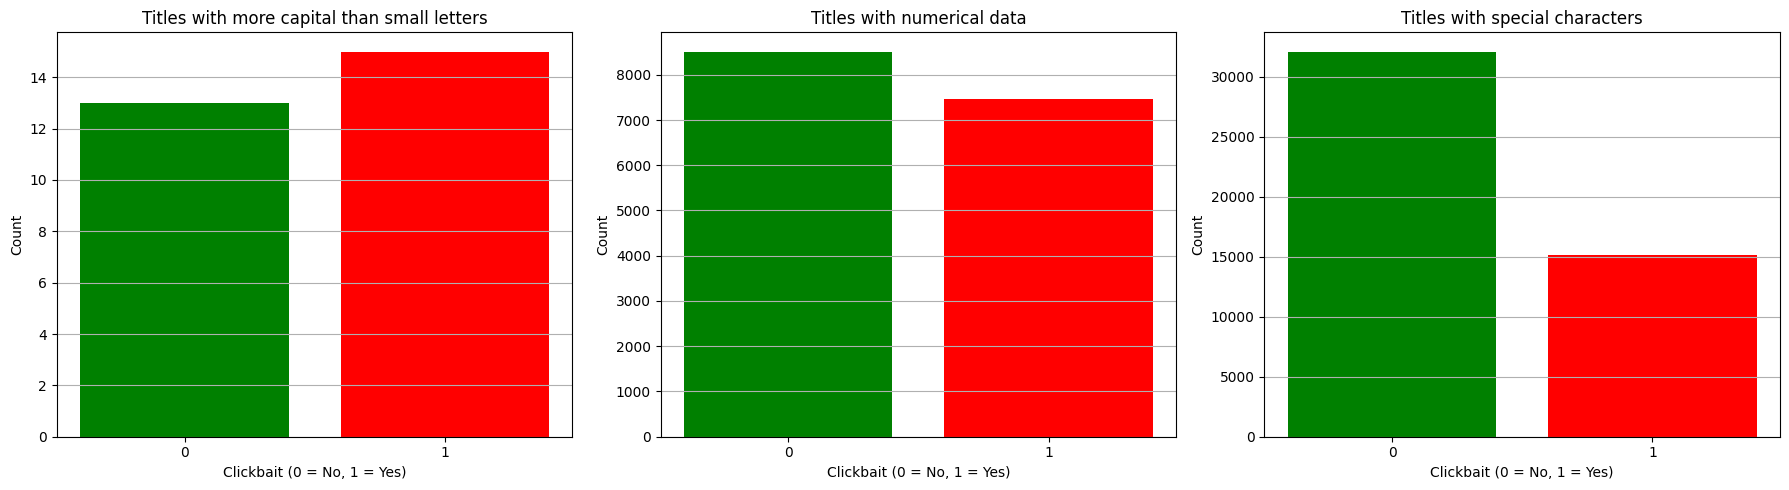

,title,clickbait
33361,When And How You Should Ask For A Raise: The D...,1
6514,Bobby Flay And His Cat Are The Most Magical Du...,1
13522,Our lack of sleep is costing the world billion...,1
4878,"Can You Answer These Obscure ""Friends"" Trivia ...",1
2314,The hottest Aussie city just had its coldest d...,1
...,...,...
40971,"NBC News Video See Brazil Soccer Team, Pilot’s...",0
40972,Politico Scoop: Eric Trump Killed Two Deer,1
40973,Frenchs Forest high school may relocate to mak...,0
40974,Los Angeles Rams Jeff Fisher May Think Danny W...,0


In [61]:
analyze_df(df_merged)

In [62]:
df_0_huge = df_merged[df_merged['clickbait'] == 0].sample(n=20000, random_state=42)
df_1_huge = df_merged[df_merged['clickbait'] == 1].sample(n=20000, random_state=42)
df_balanced_huge = pd.concat([df_0_huge, df_1_huge])

df_balanced_huge.to_csv("../data/merged_datasetes_balanced_huge.csv", index=False)

In [63]:
df_0 = df_merged[df_merged['clickbait'] == 0].sample(n=10000, random_state=42)
df_1 = df_merged[df_merged['clickbait'] == 1].sample(n=10000, random_state=42)
df_balanced = pd.concat([df_0, df_1])

df_balanced.to_csv("../data/merged_datasetes_balanced.csv", index=False)

## + Dataset with body: clickbait challange
https://webis.de/events/clickbait-challenge/shared-task.html

In [43]:
files = ["clickbait17-train-170331", "clickbait17-test-170720", "clickbait17-validation-170630"]
body_dfs = []
for filename in files:
    part_df = load_data_cc(filename, columns=["targetParagraphs"])
    part_df['body'] = part_df['targetParagraphs'].apply(lambda x: " ".join(x))
    part_df = part_df[['title', 'body', 'clickbait']]
    body_dfs.append(part_df)
df_body = pd.concat(body_dfs).reset_index(drop=True)

In [44]:
df_body['clickbait'].value_counts()

clickbait
0    30938
1    10038
Name: count, dtype: int64

In [45]:
df_body.to_csv("../data/cc_dataset.csv", index=False)

In [46]:
df_00 = df_body[df_body['clickbait'] == 0].sample(n=10000, random_state=37)
df_01 = df_body[df_body['clickbait'] == 1].sample(n=10000, random_state=37)

df_body_balanced = pd.concat([df_00, df_01])

In [47]:
df_body_balanced.to_csv("../data/cc_dataset_balanced.csv", index=False)

## Clickbait spoiling dataset

https://pan.webis.de/semeval23/pan23-web/clickbait-challenge.html

In [212]:
"""
Vocab:
task 1: spoiler type classification
task 2: spoiler generation / extraction

Columns:
targetTitle: The title of the linked web page.
targetParagraphs: The main content of the linked web page. Consists of the paragraphs of manually extracted main content.
humanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. Beware, there is a lot of missing values.
spoiler: The human extracted spoiler for the clickbait post from the linked web page.
spoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page.
tags: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in task 1 (spoiler type classification).

How to use spoilerPositions:
if `data['spoilerPositions'][0]` is `[[[3, 151], [3, 186]]]`,
then `data['targetParagraphs'][0][3][151:186]` equals `data['spoiler']`
"""

'\nVocab:\ntask 1: spoiler type classification\ntask 2: spoiler generation / extraction\n\nColumns:\ntargetTitle: The title of the linked web page.\ntargetParagraphs: The main content of the linked web page. Consists of the paragraphs of manually extracted main content.\nhumanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. Beware, there is a lot of missing values.\nspoiler: The human extracted spoiler for the clickbait post from the linked web page.\nspoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page.\ntags: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in task 1 (spoiler type classification).\n\nHow to use spoilerPositions:\nif `data[\'spoilerPositions\'][0]` is `[[[3, 151], [3, 186]]]`,\nthen `data[\'targetParagraphs\'][0][3][151:186]` equals `data[\'spoiler\']`\n'

In [213]:
names = ['train', 'validation']
spoil_dfs = []
for name in names:
    data_file_path = f'../../data/spoiling-clickbait-22/{name}.jsonl'
    with open(data_file_path, 'rb') as file:
        part_df = pd.read_json(file,lines=True)

    part_df['humanSpoiler'] = part_df['provenance'].apply(lambda x: x['humanSpoiler'])
    part_df = part_df[["targetTitle", "targetParagraphs", "humanSpoiler", "spoiler", "spoilerPositions", "tags"]]
    spoil_dfs.append(part_df)
spoil_df = pd.concat(spoil_dfs).reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/spoiling-clickbait-22/train.jsonl'

In [37]:
spoil_df.to_csv("../data/spoiling_data.csv", index=False)